## Convolution on NLP!!

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)

2.4.0


### Load and split data

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3AI7B3/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3AI7B3/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete3AI7B3/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
tokenizer = info.features['text'].encoder

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

AttributeError: 'ShuffleDataset' object has no attribute 'output_shapes'

```
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)
```
이 코드를

```
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
```
이렇게 바꾸면 됨

Also, as far as train_dataset.output_shapes goes, it has been depreciated in the latest version of TensorFlow https://www.tensorflow.org/api_docs/python/tf/data/Dataset#element_spec so if you have TF2 you can use compat.v1 or ds.element_spec


###  Modeling with Convolution layer
NLP에서도 convolutional layer를 사용할 수 있다!!!
* LSTM은 Embedding 후 lstm 레이어가 들어갔는데
* 지금은 Embedding 후 Conv1D 레이어가 들어간다.

`tf.keras.layers.Conv1D(128, 5, activation='relu`)
* Words will be **grouped** into the size of the filter in this case 5.
* We have 128 filters each 5 words.

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         41088     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
_________________________________________________________________


convolution layer에서 filter의 개수를 128개로 잡았으니 conv layer의 output shape에 128이 들어가는 것임!

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 33s 65ms/step - loss: 0.5776 - accuracy: 0.6642 - val_loss: 0.3170 - val_accuracy: 0.8747
Epoch 2/10
391/391 [==============================] - 18s 43ms/step - loss: 0.2218 - accuracy: 0.9191 - val_loss: 0.2947 - val_accuracy: 0.8804
Epoch 3/10
391/391 [==============================] - 16s 39ms/step - loss: 0.1654 - accuracy: 0.9419 - val_loss: 0.3350 - val_accuracy: 0.8719
Epoch 4/10
391/391 [==============================] - 16s 38ms/step - loss: 0.1232 - accuracy: 0.9600 - val_loss: 0.3606 - val_accuracy: 0.8667
Epoch 5/10
391/391 [==============================] - 16s 38ms/step - loss: 0.1002 - accuracy: 0.9690 - val_loss: 0.4406 - val_accuracy: 0.8654
Epoch 6/10
391/391 [==============================] - 16s 38ms/step - loss: 0.0814 - accuracy: 0.9751 - val_loss: 0.5059 - val_accuracy: 0.8603
Epoch 7/10
391/391 [==============================] - 15s 37ms/step - loss: 0.0647 - accuracy: 0.9815 - val_loss: 0.5968 - val_accuracy:

In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

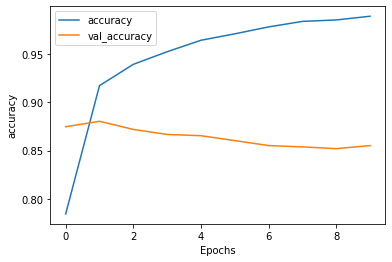

In [14]:
plot_graphs(history, 'accuracy')

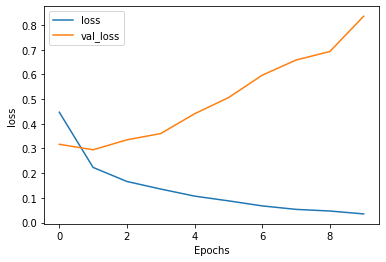

In [15]:
plot_graphs(history, 'loss')